In [82]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, block_diag, identity, hstack
import matplotlib.pyplot as plt
from pyiga import assemble, bspline, vform, geometry, vis, solvers, utils, topology, algebra, quadrature
from sksparse.cholmod import cholesky
from pyiga import adaptive as adap
import itertools
import time
import statistics as st
from pyiga import algebra_cy

np.set_printoptions(linewidth=100000)
np.set_printoptions(precision=5)
np.set_printoptions(formatter={'float_kind':"{:.3f}".format})

Populating the interactive namespace from numpy and matplotlib


/home/wolfman/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['gamma', 'cholesky', 'eig', 'identity', 'hstack']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [83]:
import time
cimport cython

import numpy as np
cimport numpy as np

from scipy.sparse import lil_matrix

cdef iter_over_lil_matrix(m):
    cdef list sums, data_row
    sums = []
    for data_row in m.data:
        s = 0
        for value in data_row:
            s += value
        sums.append(s)
    return sums

def main():
    a = np.random.random((1e4*1e4))
    a[a>0.1] = 0
    a = a.reshape(1e4,1e4)
    m = lil_matrix(a)

    t0 = time.clock()
    sums = iter_over_lil_matrix(m)
    t1 = time.clock()
    print 'Cython lil_matrix Time', t1-t0

    t0 = time.clock()
    array_sums = a.sum(axis=1)
    t1 = time.clock()
    print 'Numpy ndarray Time', t1-t0

    t0 = time.clock()
    lil_sums = m.sum(axis=1)
    t1 = time.clock()
    print 'lil_matrix Time', t1-t0

    mcsr = m.tocsr()
    t0 = time.clock()
    csr_sums = mcsr.sum(axis=1)
    t1 = time.clock()
    print 'csr_matrix Time', t1-t0

    assert np.allclose(array_sums, sums)
    assert np.allclose(array_sums, np.asarray(lil_sums).flatten())
    assert np.allclose(array_sums, np.asarray(csr_sums).flatten())

SyntaxError: invalid syntax (278535219.py, line 4)

In [74]:
n=int(50)
delta = np.ones(n, dtype=float)
gamma = 0.4*np.ones(n-1, dtype=float)
#A=scipy.sparse.spdiags(np.c_[np.r_[-gamma,0],delta,np.r_[0,-gamma]].T,[-1,0,1])
#eig = scipy.linalg.eigh_tridiagonal(delta,gamma)

In [75]:
L=algebra.LanczosMatrix(delta,gamma)

In [76]:
t=time.time()
print(algebra_cy.pyx_eval_charPolynomial(delta,gamma,0.0))
print(time.time()-t)

(1.9029969236079403e-05, -0.0015646863594109715)
0.00034689903259277344


In [77]:
t=time.time()
print(L.eval_charPolynomial(2.16))
print(time.time()-t)

(1.1904761904762002, 70.32177950545348)
0.0003216266632080078


In [80]:
t=time.time()
M=L.maxEigenvalue()
print(L.eval_charPolynomial(M))
print(time.time()-t)

5
(8.110480514637019e-29, 2.1324052752118488e-16)
0.002383708953857422


In [81]:
M

1.7984826629900157

In [50]:
t = time.time()
eig = scipy.linalg.eigh_tridiagonal(delta,gamma)
print(time.time()-t)

11.52299165725708


In [51]:
eig[0][0], eig[0][-1]

(0.20000003947052272, 1.7999999605294772)

In [17]:
max(L.mat.sum(axis=1).T.A[0])

0.8

In [13]:
1.4/0.6

2.3333333333333335

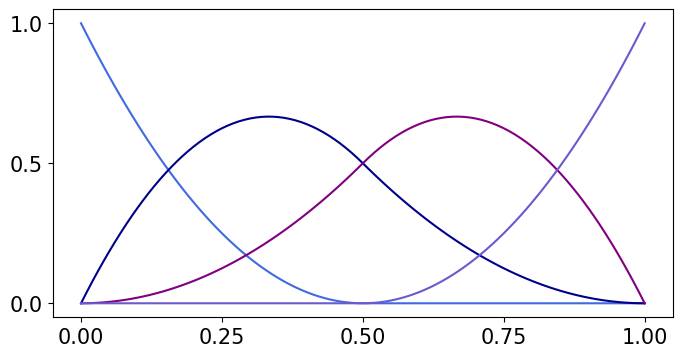

In [157]:
kv1 = bspline.make_knots(2,0.0,1.0,2)
func1 = [bspline.BSplineFunc(kv1,np.eye(1,kv1.numdofs,i).ravel()) for i in range(kv1.numdofs)]
col1=['royalblue','darkblue','purple','slateblue']
fig = plt.figure(figsize=(8,4))
for i in range(kv1.numdofs):
    plt.plot(x,func1[i](x),color=col1[i])
    plt.xticks(np.array([0,0.25,0.5,0.75,1]),fontsize=15)
    plt.yticks(np.array([0,0.5,1]),fontsize=15)
plt.show()

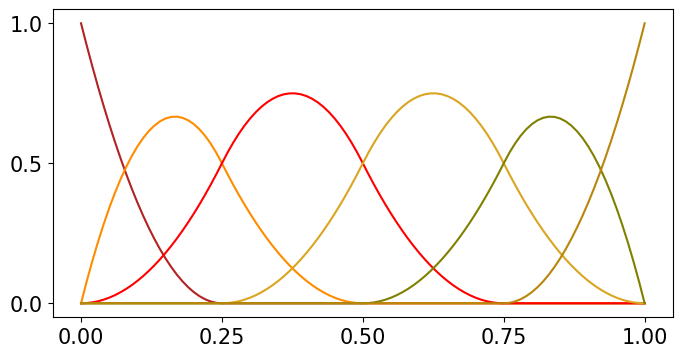

In [158]:
kv2 = bspline.make_knots(2,0.0,1.0,4)
func2 = [bspline.BSplineFunc(kv2,np.eye(1,kv2.numdofs,i).ravel()) for i in range(kv2.numdofs)]
fig = plt.figure(figsize=(8,4))
col2=['firebrick','darkorange','red','goldenrod','olive','darkgoldenrod']
for i in range(kv2.numdofs):
    plt.plot(x,func2[i](x),color=col2[i])
    plt.xticks(np.array([0,0.25,0.5,0.75,1]), fontsize=15)
    plt.yticks(np.array([0,0.5,1]),fontsize=15)
plt.show()

In [159]:
P = bspline.prolongation(kv1,kv2).tocsc()

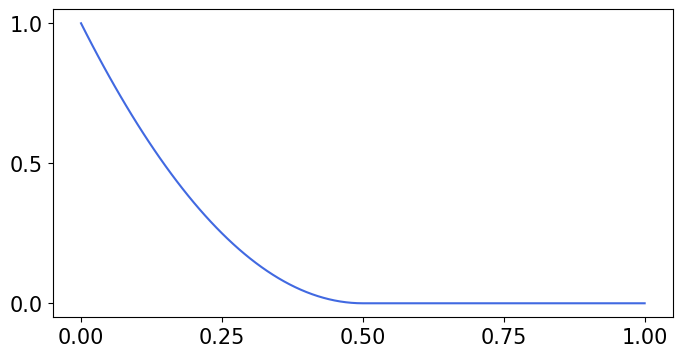

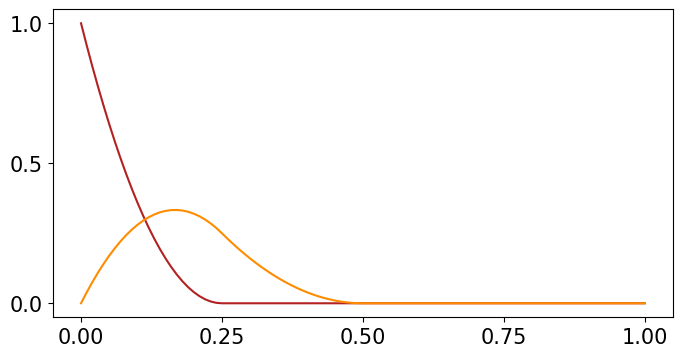

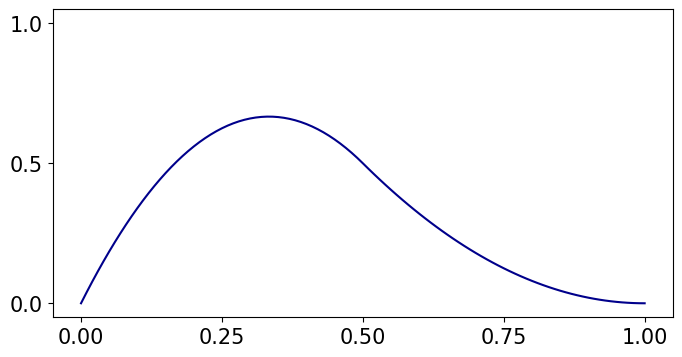

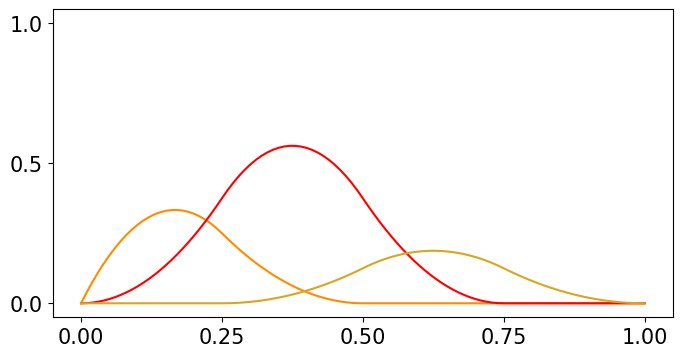

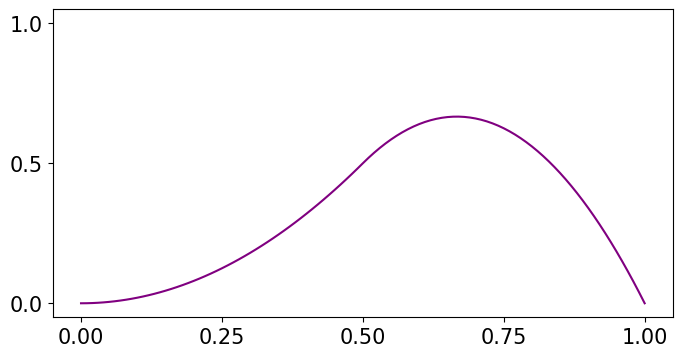

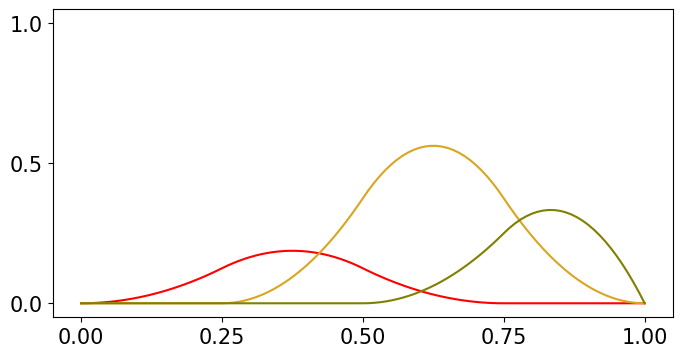

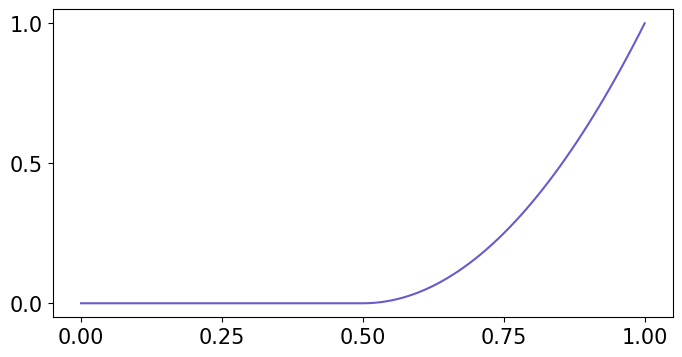

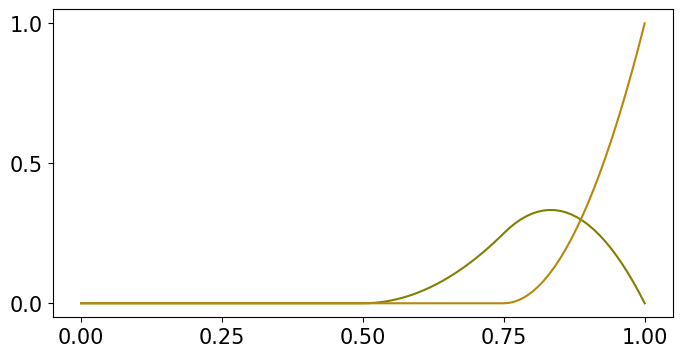

In [167]:
for j in range(P.shape[1]):
    fig = plt.figure(figsize=(8,4))
    plt.plot(x,func1[j](x),color=col1[j])
    plt.xticks(np.array([0,0.25,0.5,0.75,1]), fontsize=15)
    plt.yticks(np.array([0,0.5,1]),fontsize=15)
    plt.ylim(-0.05,1.05)
    plt.show()
    fig = plt.figure(figsize=(8,4))
    for i in P[:,j].indices:
        plt.plot(x,P[i,j]*func2[i](x),color=col2[i])
        plt.xticks(np.array([0,0.25,0.5,0.75,1]), fontsize=15)
        plt.yticks(np.array([0,0.5,1]),fontsize=15)
        plt.ylim(-0.05,1.05)
    plt.show()

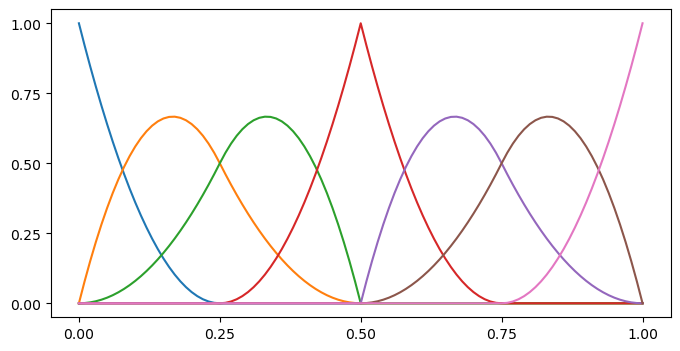

In [89]:
kv3 = bspline.KnotVector(np.array([0,0,0,0.25,0.5,0.5,0.75,1,1,1]),2)
func3 = [bspline.BSplineFunc(kv3,np.eye(1,kv3.numdofs,i).ravel()) for i in range(kv3.numdofs)]
fig = plt.figure(figsize=(8,4))
for i in range(kv3.numdofs):
    plt.plot(x,func3[i](x))
    plt.xticks(np.array([0,0.25,0.5,0.75,1]))
    plt.yticks(np.array([0,0.25,0.5,0.75,1]))
plt.show()

In [91]:
P = bspline.prolongation(kv1,kv3).A

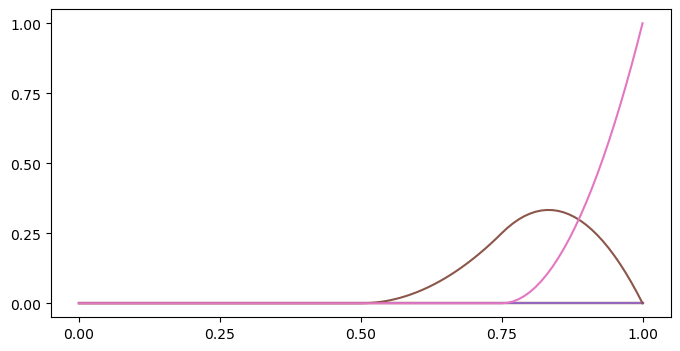

In [92]:
j=3
fig = plt.figure(figsize=(8,4))
for i in range(P.shape[0]):
    plt.plot(x,P[i,j]*func3[i](x))
    plt.xticks(np.array([0,0.25,0.5,0.75,1]))
    plt.yticks(np.array([0,0.25,0.5,0.75,1]))
plt.show()

In [83]:
kvy = [8,4,8,5,2,4]
kvx = [2,4,3,6,5,8]
deg=2

b = geometry.line_segment(np.array([0,1]),np.array([2,1])).as_nurbs()
t = geometry.line_segment(np.array([1,2]),np.array([2,2])).as_nurbs()
l = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2),coeffs=np.array([[0.,1.],[0.2,1.8],[1.,2.]]),weights = np.array([1.,1/sqrt(2),1.]))
r = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2,1.5],[2,2]]), weights = np.array([1.,1.,1.]))
kvs_g2, coeffs_g2 = geometry._combine_boundary_curves(b,t,l,r)
geo2 = geometry.NurbsFunc(kvs_g2, coeffs_g2[:,:,:2], coeffs_g2[:,:,2].reshape(3,2), premultiplied=1)

l = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2,  1.5],[2,  2  ]]), weights = np.array([1.,1.,       1.]))
r = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[3,1],[3.5,1.5],[3.5,2.5]]), weights = np.array([1.,1/sqrt(2),1.]))
b = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2.5,1  ],[3,  1  ]]), weights = np.array([1.,1.,       1.]))
t = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,2],[2.5,2.5],[3.5,2.5]]), weights = np.array([1.,1/sqrt(2),1.]))
kvs_g3, coeffs_g3 = geometry._combine_boundary_curves(b,t,l,r)
coeffs_g3[1,1] = np.array([2.75,1.75,1.0])
geo3 = geometry.NurbsFunc(kvs_g3, coeffs_g3[:,:,:2], coeffs_g3[:,:,2], premultiplied=1)

l = geometry.line_segment(np.array([2,1]),np.array([3,1])).as_nurbs()
r = geometry.line_segment(np.array([2.5,-.5]),np.array([3,0])).as_nurbs()
b = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2),coeffs=np.array([[2.,1],[2.5,0.5],[3,0]]),weights = np.array([1.,1.,1.]))
t = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[3,1],[3,0.5],[3.5,0.5]]), weights = np.array([1.,1/sqrt(2),1.]))
kvs_g4, coeffs_g4 = geometry._combine_boundary_curves(b,t,l,r)
geo4 = geometry.NurbsFunc(kvs_g4, coeffs_g4[:,:,:2], coeffs_g4[:,:,2].reshape(2,3), premultiplied=1)

l = geometry.line_segment(np.array([2,0]),np.array([2,1])).as_nurbs()
r = geometry.line_segment(np.array([3,0]),np.array([3.5,0.5])).as_nurbs()
b = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2),coeffs=np.array([[2.,0.],[2.5,0],[2.5,-.5]]),weights = np.array([1.,1/sqrt(2),1.]))
t = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2.5,0.5],[3,0]]), weights = np.array([1.,1.,1.]))
kvs_g5, coeffs_g5 = geometry._combine_boundary_curves(b,t,l,r)
geo5 = geometry.NurbsFunc(kvs_g5, coeffs_g5[:,:,:2], coeffs_g5[:,:,2].reshape(2,3), premultiplied=1)


kvs=[(bspline.make_knots(deg,0.0,1.0,xN),bspline.make_knots(deg,0.0,1.0,yN)) for xN,yN in zip(kvx,kvy)]
geos=[geometry.unit_square(support=((0.,1.),(0.0,0.5))).scale((2,1)),
      geometry.unit_square(support=((0.,1.),(0.5,1.))).scale((2,1)),
      # geometry.Quad(np.array([[0.,2.,1.,2.],
      #                         [1.,1.,2.,2.]])),
      geo2,
      geo3,
      # geometry.Quad(np.array([[2.,3.,2.,3.5],
      #                         [1.,1.,2.,2.5]])),
      geo4,
      # geometry.Quad(np.array([[2.,3.,3.,3.5],
      #                         [1.,0.,1.,0.5]])),
      geo5
     ]
      # geometry.Quad(np.array([[2.,2.5,2.,3.],
      #                         [0.,-0.5,1.,0.]])),]

patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]

conn, interfaces = assemble.detect_interfaces(patches)
for i in range(len(interfaces)):
    (p1, bdspec1, p2, bdspec2, conn_info) = interfaces[i]
    interfaces[i] = ((p1, topology.bdspec_to_int(bdspec1), 0), (p2, topology.bdspec_to_int(bdspec2), 0), conn_info[1][0])

interfaces = interfaces + [
    ((2,0,0),(0,1,0),False),
    ((2,0,1),(1,1,0),False)
]

M = topology.PatchMesh(patches, interfaces)
MP = assemble.Multipatch(M, automatch=True)
#M.sanity_check()
#M.h_refine(patches={5:-1, 2:-1});

setting up constraints took 0.012163639068603516 seconds.
Basis setup took 0.010073423385620117 seconds


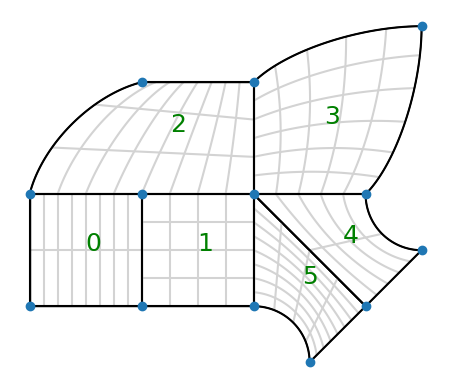

In [84]:
M.draw(knots=1, patch_idx=1, nodes=1, axis='off')
axis('scaled');

In [85]:
MP.get_crosspoints()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [88]:
loc_corners = np.concatenate([assemble.boundary_dofs(kvs,m=0,ravel=1)+MP.N_ofs[p] for p,kvs in enumerate(kvs)])
dir_dofs = np.unique(np.concatenate([assemble.boundary_dofs(kvs[p],bdspec=[assemble.int_to_bdspec(b)],ravel=1)+MP.N_ofs[p] for p,b in MP.mesh.outer_boundaries[0]]))
node_dofs = np.setdiff1d(loc_corners,dir_dofs)

In [89]:
node_dofs

array([ 39,  70,  75,  85, 126, 182, 264])

In [90]:
print(MP.Basis[node_dofs,:])

  (0, 55)	0.5
  (0, 62)	0.5
  (1, 55)	0.5
  (1, 62)	0.5
  (2, 63)	1.0
  (3, 63)	1.0
  (4, 63)	1.0
  (5, 63)	1.0
  (6, 63)	1.0


In [ ]:
{p:[(,[])] for p in range(MP.numpatches)}

In [93]:
bspline.collocation(kvs[0][0],0.25).A

array([[0.250, 0.625, 0.125, 0.000]])

In [20]:



MP.Basis.tocsc()

<193x149 sparse matrix of type '<class 'numpy.float64'>'
	with 208 stored elements in Compressed Sparse Column format>

In [279]:
def drawSkeleton(MP):
    for (p1,b1,_),(p2,b2,_),_ in MP.intfs:
        ax1,sd1=assemble.int_to_bdspec(b)
        geo=MP.mesh.geos[p]
        kvs=MP.mesh.kvs[p]
        grid1=np.linspace(geo.support[(ax1+1)%2][0], geo.support[(ax1+1)%2][1],kvs[(ax1+1)%2].numdofs)
        if (p1,b1) == (4,1) or (p1,b1)==(5,3): grid=grid[1:-1]
        if ax==0:
            Z = geo.eval(grid,np.array([geo.support[0][sd]]))
        else:
            Z = geo.eval(np.array([geo.support[1][sd]]),grid)
        plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='red',s=15,zorder=3)
    plt.axis('off');
    
def drawInterior(MP,r=1):
    for p in range(MP.numpatches):
        kvs, geo = MP.mesh.kvs[p], MP.mesh.geos[p]
        gridx=np.linspace(geo.support[0][0],geo.support[0][1] ,kvs[0].numdofs)
        gridy=np.linspace(geo.support[1][0],geo.support[1][1],kvs[1].numdofs)
        Z = geo.eval(gridx,gridy)
        if r != 0:
            plt.scatter(Z[r:-r,r:-r,0].ravel(),Z[r:-r,r:-r,1].ravel(),color='black',s=15)
        else:
            for idx in MP.mesh.outer_boundaries:
                if (p,2) not in MP.mesh.outer_boundaries[idx]: Z = Z[1:,:,:]
                if (p,3) not in MP.mesh.outer_boundaries[idx]: Z = Z[:-1,:,:]
                if (p,0) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,1:,:]
                if (p,1) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,:-1,:]
            plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='black',s=15,zorder=2)
    plt.axis('off');
    
def drawLocal(MP,ofs):
    for p in range(MP.numpatches):
        kvs, geo = MP.mesh.kvs[p], MP.mesh.geos[p]
        gridx=np.linspace(geo.support[0][0],geo.support[0][1] ,kvs[0].numdofs)
        gridy=np.linspace(geo.support[1][0],geo.support[1][1],kvs[1].numdofs)
        for idx in MP.mesh.outer_boundaries:
            if (p,2) not in MP.mesh.outer_boundaries[idx]: gridy[0]+=ofs
            if (p,3) not in MP.mesh.outer_boundaries[idx]: gridy[-1]-=ofs
            if (p,0) not in MP.mesh.outer_boundaries[idx]: gridx[0]+=ofs
            if (p,1) not in MP.mesh.outer_boundaries[idx]: gridx[-1]-=ofs
        Z = geo.eval(gridx,gridy)
        plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='royalblue',s=15,zorder=2)
    plt.axis('off');

In [283]:
deg=2
patches = [(2*(bspline.make_knots(deg,0.0,1.0,2),),geometry.unit_square())]
M = topology.PatchMesh(patches)
#M.h_refine({0:0})
#M.h_refine({0:1})
#M.h_refine({1:1})
M.h_refine({0:None});
M.h_refine({0:-1});
#M.h_refine({0:None});
M.h_refine({0:-1});
MP = assemble.Multipatch(M, automatch=True)

setting up constraints took 0.016005992889404297 seconds.
Basis setup took 0.01796555519104004 seconds


In [284]:
MP.intfs

{((1, 1, 0), (3, 0, 0), (False,)),
 ((1, 2, 0), (0, 3, 0), (False,)),
 ((2, 0, 0), (0, 1, 0), (False,)),
 ((2, 3, 0), (3, 2, 0), (False,))}

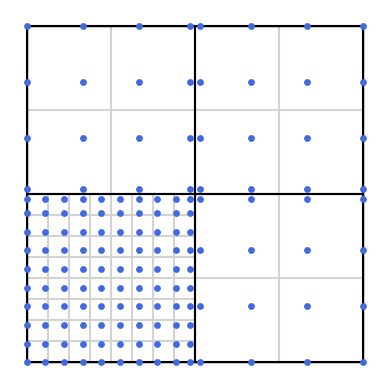

In [281]:
MP.mesh.draw(knots=1,bwidth=1)
#drawLocal(MP)
drawInterior(MP,r=0)
drawSkeleton(MP)
axis('off');
axis('scaled');

In [220]:
patches = [(2*(bspline.make_knots(1,0.0,1.0,2),),geometry.unit_square())]
M = topology.PatchMesh(patches)
M.h_refine({0:None})
M.h_refine({0:-1})
M.h_refine({0:-1})
MP = assemble.Multipatch(M, automatch=True)

setting up constraints took 0.006194114685058594 seconds.
Basis setup took 0.006829738616943359 seconds


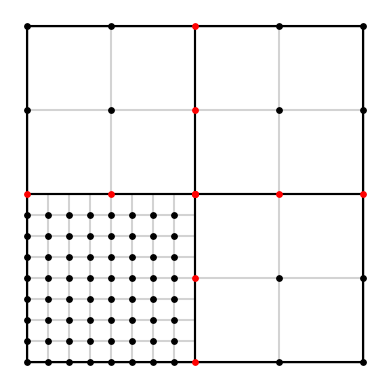

In [221]:
MP.mesh.draw(knots=1)
drawInterior(MP,r=0)
drawSkeleton(MP)

In [43]:
kv1=bspline.KnotVector(np.array([0.0,0.3,0.6,1.0]),0)
kv2=bspline.KnotVector(np.array([0.0,0.2,0.4,0.6,0.8,1.0]),0)

In [44]:
B=bspline.prolongation(kv1,kv2)

In [45]:
B.A.T

array([[1.000, 0.000, 0.000, 0.000, 0.000],
       [0.000, 1.000, 1.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, 1.000, 1.000]])

In [46]:
kvs=(kv1,kv2)

In [47]:
bspline.numspans(kvs)

15

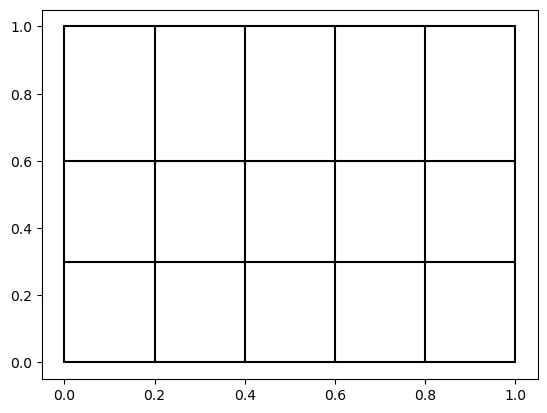

In [59]:
vis.plot_geo(geometry.unit_square(), gridx=kvs[1].mesh, gridy=kvs[0].mesh)

In [61]:
assemble.boundary_dofs(kvs, bdspec=[(0,1)], ravel=1)

array([10, 11, 12, 13, 14])

In [74]:
a={0:1}
b={0:2,3:4}

In [76]:
set(b) - set(a)

{3}

In [77]:
type('a')

str